In [1]:
import PyQt6.QtCore
import os
os.environ["QT_API"] = "pyqt5"


# Use qt backend for matplotlab to use interactive mne plots
%matplotlib qt

In [2]:
import mne 
import analysis.processing
import matplotlib.pyplot as plt
import pandas as pd
import csv 
import mne 
import analysis.processing
import matplotlib.pyplot as plt
import pandas as pd
import csv
from mne.time_frequency import csd_morlet, csd_fourier
from mne.time_frequency import tfr_morlet
import matplotlib.patches as patches 
import numpy as np
from autoreject import Ransac

mne.set_log_level(verbose='WARNING', return_old_level=False, add_frames=None)

In [4]:
# read group evokeds

oddball_list = []
control_list = []

freqs = np.arange(2, 30, 2)
n_cycles = 1
decim = 1
average = False

count = 0;

for pnum in (11, 12, 13, 21, 22, 23, 41, 42, 43, 51, 52, 53, 61, 62, \
             63, 71, 72, 73, 81, 82, 83, 91, 92, 93):
    raw = analysis.processing.loadData(pnum)

    # preprocessig 
    raw = analysis.processing.preprocessing(raw)
    epochs, event_dict = analysis.processing.eventEpocshByBlocks(raw)

    for bnum in (0, 1, 2):
        block = "b" + str(bnum)

        oddball = epochs[f"oddball & block == '{block}'"]
        control = epochs[f"control & block == '{block}'"]

        oddball_list.append(oddball.average())
        control_list.append(control.average())

        oddball_tfr = tfr_morlet(oddball, freqs,
                                n_cycles=n_cycles, decim=decim,
                                return_itc=False)
        oddball_tfr = oddball_tfr.apply_baseline((-0.2, -0.1), mode= 'ratio')
        
        control_tfr = tfr_morlet(control, freqs,
                                n_cycles=n_cycles, decim=decim,
                                return_itc=False)
        control_tfr = control_tfr.apply_baseline((-0.2, -0.1), mode= 'ratio')

        if count == 0 and bnum == 0:
             
            tfr_times = oddball_tfr.times
            tfr_freqs = oddball_tfr.freqs
            ch_names = oddball_tfr.ch_names
            tfr_info = oddball_tfr.info

            control_tfr_array = np.array([control_tfr.data])
            oddball_tfr_array = np.array([oddball_tfr.data])
        else:
            control_tfr_array = np.append(control_tfr_array, [control_tfr.data], axis = 0)
            oddball_tfr_array = np.append(oddball_tfr_array, [oddball_tfr.data], axis = 0)

    count = count +1 

evokeds = dict(
    oddball=  oddball_list,
    control= control_list,
)

c:\Users\erang\Desktop\Auditory-oddball\src\analysis\processing.py:37: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)
c:\Users\erang\Desktop\Auditory-oddball\src\analysis\processing.py:37: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)
c:\Users\erang\Desktop\Auditory-oddball\src\analysis\processing.py:37: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)
c:\Users\erang\Desktop\Auditory-oddball\src\analysis\processing.py:37: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)
c:\Users\erang\Desktop\Auditory-oddball\src\analysis\processing.py:37: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)
c:\Users\erang\Deskt

In [33]:
#save

import json
import pickle

# Create a dictionary
tfr_info = {
    'times': tfr_times.tolist(),
    'freqs': tfr_freqs.tolist(),
    'chans': ch_names,
}

# Save the dictionary to a file
with open('tfr_info.json', 'w') as json_file:
    json.dump(tfr_info, json_file)


np.save('control_tfr_array.npy', control_tfr_array)
np.save('oddball_tfr_array.npy', oddball_tfr_array)


with open('evokeds.pkl', 'wb') as file:
    pickle.dump(evokeds, file)

In [5]:
import json
import numpy as np
import pickle

with open('my_dict.json', 'r') as json_file:
    tfr_info = json.load(json_file)


control_tfr_array = np.load('control_tfr_array.npy')
oddball_tfr_array = np.load('oddball_tfr_array.npy')   


with open('evokeds.pkl', 'rb') as file:
    evokeds = pickle.load(file)


tfr_times = np.array(tfr_info["times"])
tfr_freqs = freqs = np.array(tfr_info["freqs"])   
ch_names =   tfr_info["chans"]

FileNotFoundError: [Errno 2] No such file or directory: 'my_dict.json'

In [64]:
def plotSpectrogram(chan_list):
        # Pick a time frequency region 
    # shape (5, 2, 96, 163)

    picks = chan_list

    chan_indexes =  [ch_names.index(item) for item in chan_list]


    spectrogram_control = np.mean(np.mean(control_tfr_array[:,chan_indexes, : ,:], axis = 1), axis = 0)
    spectrogram_oddball =  np.mean(np.mean(oddball_tfr_array[:,chan_indexes, : ,:], axis = 1), axis = 0)

    times = 1e3 * tfr_times  # change unit to ms

     # Calculate the global vmin and vmax for consistent color scaling
    vmin = min(np.min(spectrogram_control), np.min(spectrogram_oddball))
    vmax = max(np.max(spectrogram_control), np.max(spectrogram_oddball))


    fig, (ax, ax2) = plt.subplots(1, 2)

    im1 = ax.imshow(spectrogram_control,
            extent=[times[0], times[-1], tfr_freqs[0], tfr_freqs[-1]],
            aspect='auto', origin='lower', vmin=vmin, vmax=vmax)

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(f'Spectrogram control '+  str(picks))

    im2 = ax2.imshow(spectrogram_oddball,
            extent=[times[0], times[-1], tfr_freqs[0], tfr_freqs[-1]],
            aspect='auto', origin='lower',  vmin=vmin, vmax=vmax)

    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Frequency (Hz)')
    ax2.set_title(f'Spectrogram odd ' +  str(picks))


#     c = ax3.imshow(spectrogram_oddball - spectrogram_control,
#             extent=[times[0], times[-1], tfr_freqs[0], tfr_freqs[-1]],
#             aspect='auto', origin='lower')


#     ax3.set_xlabel('Time (ms)')
#     ax3.set_ylabel('Frequency (Hz)')
#     ax3.set_title(f'Spectrogram odd - control ' + str(picks))

    # Create a new axis for the colorbar
    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])  # [left, bottom, width, height]
    plt.colorbar(im2, cax=cbar_ax, orientation='horizontal', label="Relative Power")
   
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.4)  # wspace can be adjusted for more or less space


    plt.show()

    return spectrogram_control, spectrogram_oddball

In [34]:
def plotRoI(spectrogram_oddball, spectrogram_control, time_roi = [], freq_roi = [], chan_list = []):

    picks = chan_list

    # Pick a time frequency region 
    # shape (5, 2, 96, 163)
    diff = spectrogram_oddball - spectrogram_control
    times = 1e3 * tfr_times  # change unit to ms


    # Create figure and axes
    fig, ax = plt.subplots()

    c =  ax.imshow(diff, extent=[times[0], times[-1], freqs[0], freqs[-1]],
            aspect='auto', origin='lower')

    for index, (time_range, freq_range) in  enumerate(zip(time_roi,freq_roi )):
        rect = patches.Rectangle((time_range[0], freq_range[0]), (time_range[1] - time_range[0]), (freq_range[1] - freq_range[0]), linewidth=1, edgecolor='r', facecolor='none')
        ax.text((time_range[0]+ time_range[1])/2, (freq_range[0]+ freq_range[1])/2, f'ROI {index +1}')
        ax.add_patch(rect)

    plt.colorbar(c, label = "Relative power")


    plt.title('Oddball - Control for "' + str(picks) + '"',  fontweight ="bold")
    plt.show()

In [35]:
# get indexes of the interested regions 
def getIndexArrayOfArray ( main_array, value_list, divisor):
    index_list =[]
    for val in value_list:
        idx = np.argmin( np.abs(main_array - (val / divisor)))
        index_list.append(idx)
    return index_list

In [36]:
def getROIDataFrame ( time1idx, freq1idx, time2idx = None, freq2idx = None, chan_list = [] ):

    chan_indexes =  [ch_names.index(item) for item in chan_list]

    if((time2idx is not None) and (freq2idx is not None)):
        labels = [ 'ROI-1 Control','ROI-1 Odd','ROI-2 Control','ROI-2 Odd' ]
        data = np.zeros((4,oddball_tfr_array.shape[0]));

        # resultMat shape (5, 2, 96, 163)
        # np.mean(resultMat, axis=1)


        data[0,:] =  np.mean(np.mean(np.mean(control_tfr_array[:,chan_indexes, freq1idx[0]:freq1idx[1], time1idx[0]: time1idx[1]], axis = 3), axis = 2), axis =1)
        data[1,:] =  np.mean(np.mean(np.mean(oddball_tfr_array[:,chan_indexes, freq1idx[0]:freq1idx[1], time1idx[0]: time1idx[1]], axis = 3), axis = 2), axis =1)

        data[2,:] =  np.mean(np.mean(np.mean(control_tfr_array[:,chan_indexes, freq2idx[0]:freq2idx[1], time2idx[0]: time2idx[1]], axis = 3), axis = 2), axis =1)
        data[3,:] =  np.mean(np.mean(np.mean(oddball_tfr_array[:,chan_indexes, freq2idx[0]:freq2idx[1], time2idx[0]: time2idx[1]], axis = 3), axis = 2), axis =1)

    else:
        labels = [ 'ROI-1 Control','ROI-1 Odd'];
        data = np.zeros((2,oddball_tfr_array.shape[0]));

        # resultMat shape (5, 2, 96, 163)
        # np.mean(resultMat, axis=1)


        data[0,:] =  np.mean(np.mean(np.mean(control_tfr_array[:,chan_indexes, freq1idx[0]:freq1idx[1], time1idx[0]: time1idx[1]], axis = 3), axis = 2), axis =1)
        data[1,:] =  np.mean(np.mean(np.mean(oddball_tfr_array[:,chan_indexes, freq1idx[0]:freq1idx[1], time1idx[0]: time1idx[1]], axis = 3), axis = 2), axis =1)


    return data, labels

In [37]:
from scipy import stats
import numpy as np

def getRoIstats(data, labels):

    d_mean = np.mean(data, axis= 1)
    d_std = np.std(data, axis= 1)

    x_pos = np.arange(len(labels))

    datai = data

    for col in range(datai.shape[1] -1, -1, -1):
        variance_per_subjecti =  np.abs(datai[:,col] - d_mean)
        dist_from_2stds =  variance_per_subjecti - 2 * d_std
        # print(dist_from_2stds)
        for val in dist_from_2stds:
            if(val> 0):
                datai = np.delete(datai,(col), axis=1)
                # print("deleted")
                break;

    d_mean = np.mean(datai, axis= 1)
    d_std = np.std(datai, axis= 1) 
    n = datai.shape[1]
    yerr = d_std / np.sqrt(n) * stats.t.ppf(1-0.05/2, n - 1)   


    if datai.shape[0] > 2:
        print("T-test for the ROI 1")
        result_roi_1 = stats.ttest_ind(datai[0,:], datai[1,:])
        print("T-statistic: "+ str(result_roi_1.statistic))    
        print("P - Val : "+ str(result_roi_1.pvalue))


        print("T-test for the ROI 2")
        result_roi_1 = stats.ttest_ind(datai[2,:], datai[3,:])
        print("T-statistic: "+ str(result_roi_1.statistic))  
        print("P - Val : "+ str(result_roi_1.pvalue))

    else:
        print("T-test for the ROI 1")
        result_roi_1 = stats.ttest_ind(datai[0,:], datai[1,:])
        print("T-statistic: "+ str(result_roi_1.statistic)) 
        print("P - Val : "+ str(result_roi_1.pvalue))    
        

    # Build the plot
    fig, ax = plt.subplots()
    ax.bar(x_pos, d_mean, yerr=yerr, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Relative power')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title('Conditional power for each ROI')
    ax.yaxis.grid(True)

    # Save the figure and show
    plt.tight_layout()
    # plt.savefig('bar_plot_with_error_bars.png')
    plt.show()

In [3]:
# read group evokeds

oddball_list = []
control_list = []

freqs = np.arange(2, 30, 2)
n_cycles = 1
decim = 1
average = False

count = 0;
rsc = Ransac()

for pnum in (
            # 11, 12, 13, # some noisy 
            #21, 22, 23,  # not bad but lil noisy
            #  41, 42, 43,  # not bad but lil noisy 1R
            #  51, 52, 53,  # some noisy  5 Lb might remove
            #  61, 62, 63, # decent 1RD
            #  71, 72, 73, # frontal areas super noisy mit remoove
            #  81, 82, 83,  #not bad but noisy
            # 91, 92, 93,  # some noisy remove
             101, 102, 103 # noisy remove
             ):
    raw = analysis.processing.loadData(pnum)

    # preprocessig 
    raw = analysis.processing.preprocessing(raw)
    epochs, event_dict = analysis.processing.eventEpocshByBlocks(raw)

    for bnum in (0, 1, 2):
        block = "b" + str(bnum)

        oddball = epochs[f"oddball & block == '{block}'"]
        control = epochs[f"control & block == '{block}'"]
        

        # ob_epochs_clean = rsc.fit_transform(oddball) 
        # control_epochs_clean = rsc.fit_transform(control) 

        oddball_list.append(oddball.average())
        control_list.append(control.average())

evokedssss = dict(
    oddball=  oddball_list,
    control= control_list,
)
analysis.processing.getERPMontage(evokedssss)

c:\Users\erang\Desktop\Auditory-oddball\src\analysis\processing.py:37: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)
c:\Users\erang\Desktop\Auditory-oddball\src\analysis\processing.py:37: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)
c:\Users\erang\Desktop\Auditory-oddball\src\analysis\processing.py:37: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


In [5]:
analysis.processing.getERPMontage(evokeds)

In [6]:
evooddballs =evokeds['oddball']
evoodcontrol =evokeds['control']
info = evooddballs[0].info

evo_oddball_data_list_array = np.array([ ob.get_data() for ob in evooddballs])
evo_control_data_list_array = np.array([ ob.get_data() for ob in evoodcontrol])

ob_evoked_array = mne.EvokedArray(
    np.mean(evo_oddball_data_list_array, 0) * 1e6, info, tmin=-0.2, nave=evo_oddball_data_list_array.shape[0], comment="odd balls"
)

control_evoked_array = mne.EvokedArray(
    np.mean(evo_control_data_list_array, 0) * 1e6, info, tmin=-0.2, nave=evo_control_data_list_array.shape[0], comment="odd balls"
)
times = np.arange(-0.05, 0.6, 0.05)

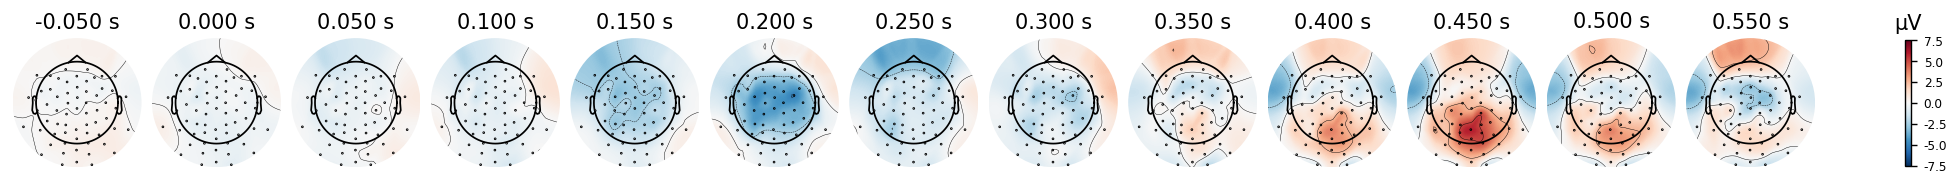

In [9]:
ob_evoked_array.plot_topomap(times, ch_type="eeg",vlim= (-7.5, 7.5))

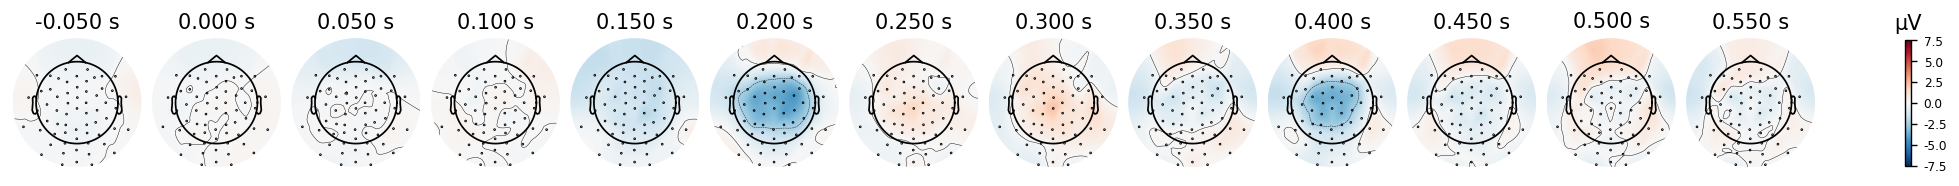

In [8]:
control_evoked_array.plot_topomap(times, ch_type="eeg", vlim= (-7.5, 7.5))

In [ ]:
import matplotlib.animation as animation 
writervideo = animation.FFMpegWriter(fps=60) 

times = np.arange(-0.05, 0.6, 0.01)
fig, anim = ob_evoked_array.animate_topomap(times=times, ch_type="eeg", frame_rate= 8, blit=False, vmin =-7.5, vmax= 7.5, butterfly= True)
anim.save('ob_evoked_topo.gif', writer="ffmpeg") 
fig, anim = control_evoked_array.animate_topomap(times=times, ch_type="eeg", frame_rate= 8, blit=False, vmin =-7.5, vmax= 7.5, butterfly= True)
anim.save('control_evoked_topo.gif', writer="ffmpeg") 

In [27]:
#front
#   - 1LD
#   - 1RD
#   - 1RB
#   - 1LB
#   - 1L
#   - 1Z
#   - 1R




# roi = ['1LC', '2L', '2R', '1RC']


roi = ['1L', '1R','1Z','1LC', '1LB', '2L', '2R', '1RB', '1RC']
ci = 0.95
invert = False

fig, ax = plt.subplots()
mne.viz.plot_compare_evokeds(evokeds, picks= roi, ci = ci , 
                                styles = {"oddball": {"color" :'red'}, 
                                        "control":{"color": 'blue'}}, 
                                    show =False, axes = ax, combine ='mean' )
if(invert): 
    ax.invert_yaxis()
    
ax.set_ylabel("V")

ax.set_title("ERP of the frontal channels")

plt.show()

In [28]:
#Occipital

roi = ['10L', '9Z','10R', '9L', '8Z', '9R']
ci = 0.95
invert = False

fig, ax = plt.subplots()
mne.viz.plot_compare_evokeds(evokeds, picks= roi, ci = ci , 
                                styles = {"oddball": {"color" :'red'}, 
                                        "control":{"color": 'blue'}}, 
                                    show =False, axes = ax, combine ='mean' )
if(invert): 
    ax.invert_yaxis()
    
ax.set_ylabel("V")
ax.set_title("ERP of the occiptal channels")

plt.show()

In [29]:
#Left

roi = ['3LB', '3LC','2LB', '1LA', '2LA', '2LC']
ci = 0.95
invert = False

fig, ax = plt.subplots()
mne.viz.plot_compare_evokeds(evokeds, picks= roi, ci = ci , 
                                styles = {"oddball": {"color" :'red'}, 
                                        "control":{"color": 'blue'}}, 
                                    show =False, axes = ax, combine ='mean' )
if(invert): 
    ax.invert_yaxis()
    
ax.set_ylabel("V")
ax.set_title("ERP of the left channels")

plt.show()

In [30]:
#Right

roi = ['3RB', '3RC','2RB', '1RA', '2RA', '2RC']
ci = 0.95
invert = False

fig, ax = plt.subplots()
mne.viz.plot_compare_evokeds(evokeds, picks= roi, ci = ci , 
                                styles = {"oddball": {"color" :'red'}, 
                                        "control":{"color": 'blue'}}, 
                                    show =False, axes = ax, combine ='mean' )
if(invert): 
    ax.invert_yaxis()
    
ax.set_ylabel("V")
ax.set_title("ERP of the right channels")

plt.show()

In [11]:
diff_waves = []
for i in range(len(oddball_list)):
    diff_waves.append(mne.combine_evoked([oddball_list[i], control_list[i]], weights=[-1, 1]))

In [15]:
#plot evokeds at 0.95 CI
roi =['7Z']
analysis.processing.getERP(evokeds, roi = roi, ci = 0.95, invert = True, vlines = [0.0])

In [14]:
import matplotlib.pyplot as plt
roi = ['7Z']
invert = True

contrast = 'Oddball - Control'
fig, ax = plt.subplots()
mne.viz.plot_compare_evokeds({contrast:diff_waves},
                            legend=None, title=contrast,
                             picks=roi, ci =0.95, axes= ax ,vlines = [0.0, 0.2610,0.445]
                            )
if(invert): 
    ax.invert_yaxis()
    
ax.set_ylabel("V")
plt.show()

In [16]:
import numpy as np
evoked_data = np.array([ [np.mean(np.mean(e.get_data(picks=roi, tmin= 0.3591, tmax= 0.5), axis=1), axis=0)] for e in diff_waves])
from scipy import stats 

result = stats.ttest_1samp(evoked_data, 0)
t =  result.statistic
print(result)
pval = result.pvalue
# df = result.df
# print('t( df = ', str(round(df[0], 2)) ,')= ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))
print('P300 t( df = 81)= ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))

Ttest_1sampResult(statistic=array([-7.29184025]), pvalue=array([3.4142752e-10]))
P300 t( df = 81)=  -7.29 p =  0.0


In [17]:
import numpy as np
evoked_data = np.array([ [np.mean(np.mean(e.get_data(picks=roi, tmin=.2422, tmax=.3040), axis=1), axis=0)] for e in diff_waves])
from scipy import stats 

result = stats.ttest_1samp(evoked_data, 0)
t =  result.statistic
print(result)
pval = result.pvalue
# df = result.df
# print('t( df = ', str(round(df[0], 2)) ,')= ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))
print(' N200 t( df = 81)= ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))

Ttest_1sampResult(statistic=array([3.18105337]), pvalue=array([0.00217662]))
 N200 t( df = 81)=  3.18 p =  0.0022


In [23]:
#plot evokeds at 0.95 CI
analysis.processing.getERP(evokeds, roi = ['2Z'], ci = 0.95, invert = True, vlines=[0.0])

In [22]:
import matplotlib.pyplot as plt
roi = ['2Z']
invert = True

contrast = 'Oddball - Control'
fig, ax = plt.subplots()
mne.viz.plot_compare_evokeds({contrast:diff_waves},
                            legend=None, title=contrast,
                             picks=roi, ci =0.95, axes= ax ,vlines = [0.0, 0.292]
                            )
if(invert): 
    ax.invert_yaxis()
    
ax.set_ylabel("V")
plt.show()

In [21]:
import numpy as np
evoked_data = np.array([ [np.mean(np.mean(e.get_data(picks=['2Z'], tmin=.251, tmax=.343), axis=1), axis=0)] for e in diff_waves])
from scipy import stats 

result = stats.ttest_1samp(evoked_data, 0)
t =  result.statistic
print(result)
pval = result.pvalue
# df = result.df
# print('t( df = ', str(round(df[0], 2)) ,')= ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))
print(' N200 t( df = 81)= ', str(round(t[0], 2)), 'p = ', str(round(pval[0], 4)))

Ttest_1sampResult(statistic=array([5.67794855]), pvalue=array([2.7762347e-07]))
 N200 t( df = 81)=  5.68 p =  0.0


In [67]:
chan_list = ['7Z']
spectrogram_control, spectrogram_oddball = plotSpectrogram(chan_list)
time_roi = [[275, 400], [450, 550]]
freq_roi = [[2, 5], [2, 4]] 
plotRoI(spectrogram_oddball, spectrogram_control, time_roi, freq_roi, chan_list)

time1idx = getIndexArrayOfArray(tfr_times, time_roi[0], 1e3)
time2idx = None
if(len(time_roi) > 1): 
    time2idx = getIndexArrayOfArray(tfr_times, time_roi[1], 1e3) 

freq1idx = getIndexArrayOfArray(tfr_freqs, freq_roi[0], 1)
freq2idx = None
if(len(freq_roi) > 1):  
    freq2idx = getIndexArrayOfArray(tfr_freqs, freq_roi[1], 1) 

data, labels = getROIDataFrame (time1idx,freq1idx, time2idx, freq2idx, chan_list )
getRoIstats(data, labels)

T-test for the ROI 1
T-statistic: -5.752772234625404
P - Val : 7.498683482453338e-08
T-test for the ROI 2
T-statistic: -6.478649824969775
P - Val : 2.4417890037972985e-09


In [65]:
chan_list = ['2Z']
spectrogram_control, spectrogram_oddball = plotSpectrogram(chan_list)
time_roi = [[262, 507]]
freq_roi = [[2, 4]] 
plotRoI(spectrogram_oddball, spectrogram_control, time_roi, freq_roi, chan_list)

time1idx = getIndexArrayOfArray(tfr_times, time_roi[0], 1e3)
time2idx = None
if(len(time_roi) > 1): 
    time2idx = getIndexArrayOfArray(tfr_times, time_roi[1], 1e3) 

freq1idx = getIndexArrayOfArray(tfr_freqs, freq_roi[0], 1)
freq2idx = None
if(len(freq_roi) > 1):  
    freq2idx = getIndexArrayOfArray(tfr_freqs, freq_roi[1], 1) 

data, labels = getROIDataFrame (time1idx,freq1idx, time2idx, freq2idx, chan_list )
getRoIstats(data, labels)

T-test for the ROI 1
T-statistic: -4.40299597663663
P - Val : 2.230103741794546e-05


In [66]:
# frontal 
chan_list = ['1L', '1R','1Z','1LC', '1LB', '2L', '2R', '1RB', '1RC']
spectrogram_control, spectrogram_oddball = plotSpectrogram(chan_list)
time_roi = [[250, 550]]
freq_roi = [[2, 4]] 
plotRoI(spectrogram_oddball, spectrogram_control, time_roi, freq_roi, chan_list)

time1idx = getIndexArrayOfArray(tfr_times, time_roi[0], 1e3)
time2idx = None
if(len(time_roi) > 1): 
    time2idx = getIndexArrayOfArray(tfr_times, time_roi[1], 1e3) 

freq1idx = getIndexArrayOfArray(tfr_freqs, freq_roi[0], 1)
freq2idx = None
if(len(freq_roi) > 1):  
    freq2idx = getIndexArrayOfArray(tfr_freqs, freq_roi[1], 1) 

data, labels = getROIDataFrame (time1idx,freq1idx, time2idx, freq2idx, chan_list )
getRoIstats(data, labels)

T-test for the ROI 1
T-statistic: -3.058690421393303
P - Val : 0.002707953188752907


In [60]:
# occipital  
chan_list = ['10L', '9Z','10R', '9L', '8Z', '9R']
spectrogram_control, spectrogram_oddball = plotSpectrogram(chan_list)
time_roi = [[250, 350]]
freq_roi = [[2, 4]] 
plotRoI(spectrogram_oddball, spectrogram_control, time_roi, freq_roi, chan_list)

time1idx = getIndexArrayOfArray(tfr_times, time_roi[0], 1e3)
time2idx = None
if(len(time_roi) > 1): 
    time2idx = getIndexArrayOfArray(tfr_times, time_roi[1], 1e3) 

freq1idx = getIndexArrayOfArray(tfr_freqs, freq_roi[0], 1)
freq2idx = None
if(len(freq_roi) > 1):  
    freq2idx = getIndexArrayOfArray(tfr_freqs, freq_roi[1], 1) 

data, labels = getROIDataFrame (time1idx,freq1idx, time2idx, freq2idx, chan_list )
getRoIstats(data, labels)

T-test for the ROI 1
T-statistic: -3.6311621378310455
P - Val : 0.00039857308065617254


In [61]:
# left  
chan_list = ['3LB', '3LC','2LB', '1LA', '2LA', '2LC']
spectrogram_control, spectrogram_oddball = plotSpectrogram(chan_list)
time_roi = [[250, 550]]
freq_roi = [[2, 4]] 
plotRoI(spectrogram_oddball, spectrogram_control, time_roi, freq_roi, chan_list)

time1idx = getIndexArrayOfArray(tfr_times, time_roi[0], 1e3)
time2idx = None
if(len(time_roi) > 1): 
    time2idx = getIndexArrayOfArray(tfr_times, time_roi[1], 1e3) 

freq1idx = getIndexArrayOfArray(tfr_freqs, freq_roi[0], 1)
freq2idx = None
if(len(freq_roi) > 1):  
    freq2idx = getIndexArrayOfArray(tfr_freqs, freq_roi[1], 1) 

data, labels = getROIDataFrame (time1idx,freq1idx, time2idx, freq2idx, chan_list )
getRoIstats(data, labels)

T-test for the ROI 1
T-statistic: -4.198336905545079
P - Val : 4.951892611439467e-05


In [58]:
# right  
chan_list =  ['3RB', '3RC','2RB', '1RA', '2RA', '2RC']
spectrogram_control, spectrogram_oddball = plotSpectrogram(chan_list)
time_roi = [[250, 550]]
freq_roi = [[2, 4]] 
plotRoI(spectrogram_oddball, spectrogram_control, time_roi, freq_roi, chan_list)

time1idx = getIndexArrayOfArray(tfr_times, time_roi[0], 1e3)
time2idx = None
if(len(time_roi) > 1): 
    time2idx = getIndexArrayOfArray(tfr_times, time_roi[1], 1e3) 

freq1idx = getIndexArrayOfArray(tfr_freqs, freq_roi[0], 1)
freq2idx = None
if(len(freq_roi) > 1):  
    freq2idx = getIndexArrayOfArray(tfr_freqs, freq_roi[1], 1) 

data, labels = getROIDataFrame (time1idx,freq1idx, time2idx, freq2idx, chan_list )
getRoIstats(data, labels)

T-test for the ROI 1
T-statistic: -4.270955778928393
P - Val : 3.7995083327698316e-05
